In [1]:
import sys
import os

# Add the project directory to the Python path
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
!pip install pandas openpyxl
!pip install statsmodels
!pip install arch
!pip install tensorflow
!pip install boto3
!pip install requests
!pip install numpy
!pip install joblib matplotlib
!pip install prophet
!pip install tabulate

In [3]:
import pandas as pd
import numpy as np
import boto3
import joblib
import tarfile
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scripts.preprocessing import load_data_csv, make_stationary, split_data, save_model_local, upload_model_s3, calculate_metrics
from prophet import Prophet
from scipy import stats
import seaborn as sns
from tabulate import tabulate

In [4]:
bucket = 'bk-price-prediction-data'
file_key = 'data/PATATAS/PATATAS_DATASET_1.csv'
separator = ','
df = load_data_csv(bucket, file_key, separator)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   COUNTRY  444 non-null    object
 1   YEAR     444 non-null    int64 
 2   PRICE    444 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.5+ KB


In [5]:
df.where(df['PRICE']== ':').replace(':', np.nan, inplace= True)
df.dropna(inplace=True)
df

/tmp/ipykernel_8967/2593566721.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.where(df['PRICE']== ':').replace(':', np.nan, inplace= True)


,COUNTRY,YEAR,PRICE
0,Belgium,2012,16.81
1,Bulgaria,2012,19.02
2,Czechia,2012,11.25
3,Denmark,2012,16.29
4,Germany,2012,13
...,...,...,...
439,Montenegro,2023,:
440,North Macedonia,2023,:
441,Albania,2023,:
442,Serbia,2023,:


In [6]:
df_filter = df[df['PRICE'] != ':']
df_filter

,COUNTRY,YEAR,PRICE
0,Belgium,2012,16.81
1,Bulgaria,2012,19.02
2,Czechia,2012,11.25
3,Denmark,2012,16.29
4,Germany,2012,13
...,...,...,...
429,Romania,2023,56.4
430,Slovenia,2023,47.58
431,Slovakia,2023,51.07
432,Finland,2023,21.63


In [7]:
df_filter.info()
df_filter.tail()
df_filter['PRICE'] = df_filter['PRICE'].astype('float64')
df_filter['YEAR'] = pd.to_datetime(df_filter['YEAR'], format='%Y')
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 433
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   COUNTRY  301 non-null    object
 1   YEAR     301 non-null    int64 
 2   PRICE    301 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 433
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   COUNTRY  301 non-null    object        
 1   YEAR     301 non-null    datetime64[ns]
 2   PRICE    301 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.4+ KB


/tmp/ipykernel_8967/3775740761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['PRICE'] = df_filter['PRICE'].astype('float64')
/tmp/ipykernel_8967/3775740761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['YEAR'] = pd.to_datetime(df_filter['YEAR'], format='%Y')


In [8]:
# Remove outliers from the DataFrame
df_filter = df_filter[(np.abs(stats.zscore(df_filter['PRICE'])) < 3)]
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 433
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   COUNTRY  297 non-null    object        
 1   YEAR     297 non-null    datetime64[ns]
 2   PRICE    297 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.3+ KB


In [9]:
# Normalize data
scaler = MinMaxScaler()
df_filter['PRICE'] = scaler.fit_transform(df_filter[['PRICE']])

/tmp/ipykernel_8967/1331593699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['PRICE'] = scaler.fit_transform(df_filter[['PRICE']])


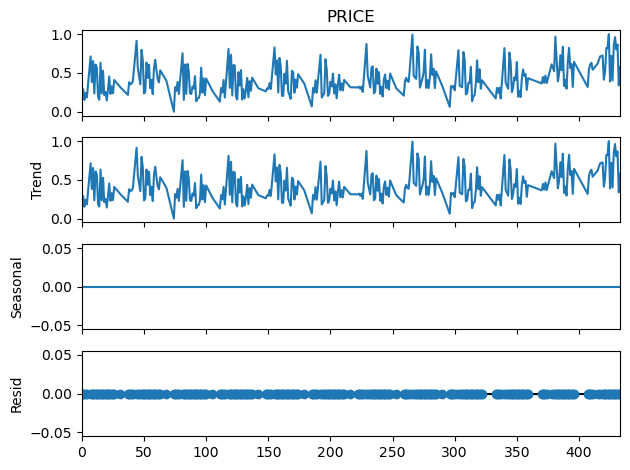

In [10]:
#df_filter = df_filter.asfreq('Y')
df_filter = df_filter.dropna(subset=['PRICE'])
# print(df_filter.index.inferred_freq)
decomposition = seasonal_decompose(df_filter['PRICE'], model='additive', period=1)

# Plot the decomposition
decomposition.plot()
plt.show()

In [11]:
# Prepare data for Prophet
df_prophet = df_filter.reset_index().rename(columns={'YEAR': 'ds', 'PRICE': 'y'})

In [12]:
train, test = split_data(df_prophet)

In [13]:
# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.1,  # Adjust this parameter
    seasonality_prior_scale=10.0  # Adjust this parameter
)
model.fit(train)

21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:46 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Make predictions
forecast = model.predict(test)

In [15]:
# Evaluate the model
predictions = forecast['yhat'][-len(test):].values
true_values = test['y'].values

In [16]:
results=calculate_metrics(true_values,predictions)

In [17]:
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

+----------+------------+
| Metric   |      Value |
+==========+============+
| MAE      |  0.18209   |
+----------+------------+
| MSE      |  0.0549305 |
+----------+------------+
| RMSE     |  0.234373  |
+----------+------------+
| MAPE     | 32.0796    |
+----------+------------+


In [18]:
name_model = 'model_patatas'
save_model_local(model,name_model)

Created ../model/model_patatas.tar.gz containing ../model/model_patatas.joblib


In [19]:
# Upload the model to S3
upload_model_s3(name_model, bucket)

upload s3
